# This notebook shows how to fit data to steady-state enzyme kinetics using non-linear fit and linearization method 


#### Import reqired python modules

In [10]:
import numpy as np # numeric python module for vectorized operations on arrays 
import pandas # convenience wrap for numpy 
from scipy.integrate import odeint # function for solving ordinary differential equations
from scipy.special import lambertw # implementation of Lambert W function
from scipy.optimize import minimize,basinhopping,differential_evolution #optimization algorithms
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt # plotting graphics library
#%matplotlib auto
#plt.ioff() # I prefer to output graphs into separate windows rather than showing them inline.
%matplotlib inline 

# Set up general variables

In [11]:
#linear scale of [S]o
listSo=  [0,20,40,60,80,100,120,140,160] # initial substrate  concentrations (list if floats)
Smax=160
#reciprocal scale of [S]o
#listSo=  [Smax/7,Smax/6,Smax/5,Smax/4,Smax/3,Smax/2,Smax/1] # initial substrate  concentrations (list if floats)
listSTR = list(map(str, listSo))

noise_level=.01 # we may add some random noise to the data
noise=True #if False, no noise will be added to original data 
time_cutoff=10 # number of data points used for linear regression to estimate [S]o 

simulate_data=True #if False, data will be loaded from '../data/simulatedMM_variable_S.csv'  # Input experimental data
simulate_rates=True #if False, data will be loaded from '../data/rates.csv'


#### Generate a data set using Sequential kinetic model;
$$E+S \underset{k_{-1}}
{\overset{k_{1}}{\rightleftharpoons}} ES\overset{k_{2}}{\rightarrow}E+P$$
$$\left [ \frac{\mathrm{d} [S]}{\mathrm{d} t}=k_{-1}[ES]-k_{1}[E][S];\; \frac{\mathrm{d} [E]}{\mathrm{d} t}=k_{-1}[ES]+k_{2}[ES]-k_{1}[E][S];\; \frac{\mathrm{d} [ES]}{\mathrm{d} t}=k_{1}[E][S]]-k_{-1}[ES]-k_{2}[ES];\;\frac{\mathrm{d} [P]}{\mathrm{d} t}=k_{2}[ES] \right ]$$

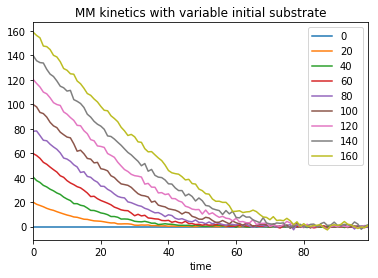

In [12]:
def model_full(init,t,*args): 
    '''Complete Sequential kinetics model'''
    S,E,SE,P=init
    k1,k1r,k2=args
    dSdt=-k1*S*E+k1r*SE
    dEdt=-k1*S*E+k1r*SE+k2*SE
    dSEdt=k1*S*E-k1r*SE-k2*SE
    dPdt=k2*SE
    return (dSdt,dEdt,dSEdt,dPdt)

E=0.01
SE=0
P=0
k1=10
k1r=1
k2=400
KM=(k2+k1r)/k1
Vm=k2*E
kcat=k2
exact='True MM parameters: KM={}; Vmax={}; Vmax/KM={}'.format(KM,Vm,Vm/KM)
t = np.linspace(0,99,100) # make an array of time points

data=pandas.DataFrame() #initiate a Pandas DataFrame for data collection
data['time']=t #make first column containing independent variable time
#data=pandas.DataFrame()
#data['time']=t
for conc in listSo:
    So=conc
    init=(So,E,SE,P)# pack initial conditions into tuple
    args=(k1,k1r,k2) # pack arguments into tuple
    z = odeint(model_full,init,t,args) # solve model_full by integration of ordinary differential equations (ODE)
    z=z[:,0]
    if noise==True:
        noiseZ = np.random.normal(0, 1, z.shape)*z.max()*noise_level
        z=z+noiseZ
    data[str(So)]=z
data.plot(x='time',y=listSTR,kind='line',
          title='MM kinetics with variable initial substrate') 
# Lazy way to plot a DataFrame 
#data.to_csv('../data/simulatedMM_variable_S.csv',index=False) #save the table into a file


#### Extract [S]o from each progress curve in the set 
explore effect of parameter time_cutoff (the lager its value the less accurate [S]o estimate)

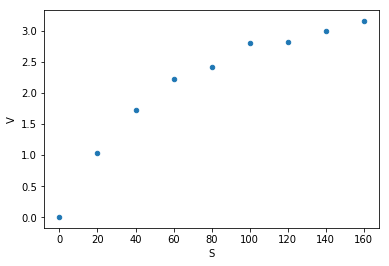

In [13]:
if simulate_data==False:
    data=pandas.read_csv('../data/simulatedMM_variable_S.csv')  # Input experimental data
velocities=pandas.DataFrame()
velocities['S']=listSo
data=data[:time_cutoff]
V=[]
for conc in listSTR:
    NF=-np.polyfit(data.time,data[str(conc)],1)
    V.append(NF[0])
velocities['V']=V
if simulate_rates==False:
    velocities=pandas.read_csv('../data/rates.csv')  # Input simulated data
    #velocities=pandas.read_csv('../data/sialidase_Neu2_vs_GM3.csv')  # Input experimental data




#velocities.to_csv('../data/rates.csv',index=False) #save the table into a file

velocities.plot(x='S',y='V',kind='scatter')


### Fit data to MM formula using non-linear fitting 

KM = 60.07471+/-4.766439
Vmax = 4.32392+/-0.133788
Found MM parameters: KM=60.07471; Vmax=4.32392; Vmax/KM=0.0719757115764687
True MM parameters: KM=40.1; Vmax=4.0; Vmax/KM=0.0997506234413965


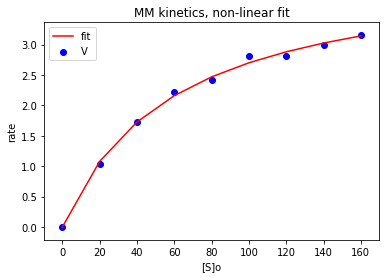

In [14]:
def model(S, KM,Vmax):
            return Vmax*S/(KM+S)
       
popt, pcov = curve_fit(model, velocities.S, velocities.V)
KM=round(popt[0],5)
KMsd=round(np.sqrt(pcov[0][0]),6)
Vmax=round(popt[1],5)
Vsd=round(np.sqrt(pcov[1][1]),6)
print('KM = {}+/-{}'.format(KM,KMsd))
print('Vmax = {}+/-{}'.format(Vmax,Vsd))
print('Found MM parameters: KM={}; Vmax={}; Vmax/KM={}'.format(KM,Vmax,Vmax/KM))
print(exact)
velocities['fit']=model(velocities.S,KM,Vmax) # add a column with fitted values to our DataFrame 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('[S]o')
ax.set_ylabel('rate')
plt.plot(velocities['S'],velocities['fit'], c='red')
plt.scatter(velocities['S'],velocities['V'],c='blue')
plt.legend()
plt.title('MM kinetics, non-linear fit')
plt.show()

### Lineweaver–Burk double reciprocal plot
$$\frac{1}{V}=\frac{{K_{M}}}{V_{max}[S]}+\frac{1}{V_{max}}$$
We use np.polyfit function with polynomial degree=1 to obtain coefficients for linear regression y=ax+b,
where coefficient a=KM/Vmax intercept b=1/Vmax
hence Vmax=1/b and KM=a/b

Found MM parameters: KM=67.0666; Vmax=4.5366; Vmax/KM=0.06764320839285129
True MM parameters: KM=40.1; Vmax=4.0; Vmax/KM=0.0997506234413965


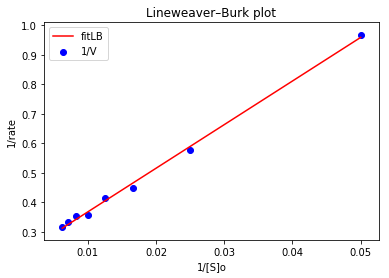

In [15]:
velocities['1/S']=1/velocities['S']
velocities['1/V']=1/velocities['V']
velocities=velocities.replace([np.inf, -np.inf], np.nan)
velocities.dropna(inplace=True)
PF=np.polyfit(velocities['1/S'],velocities['1/V'],1)
a=PF[0]
b=PF[1]
KM=round(a/b,4)
Vmax=round(1/b,4)
velocities['fitLB']=velocities['1/S']*a+b
print('Found MM parameters: KM={}; Vmax={}; Vmax/KM={}'.format(KM,Vmax,Vmax/KM))
print(exact)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('1/[S]o')
ax.set_ylabel('1/rate')
plt.plot(velocities['1/S'],velocities['fitLB'], c='red')
plt.scatter(velocities['1/S'],velocities['1/V'],c='blue')
plt.legend()
plt.title('Lineweaver–Burk plot')
plt.show()
